## <center>DataLab Cup 2: CNN for Object Detection</center>

### Dataset

In [11]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

classes_label = [i for i in range(20)]
classes_name_to_label = dict(zip(classes_name, classes_label))

### Processed data format

In [12]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


### Import Package and Check Environment

In [13]:
import tensorflow as tf
import numpy as np
import random
from utils import *
from matplotlib import pyplot as plt
import os
import cv2 as cv
from data_aug.data_aug import RandomHorizontalFlip, RandomHSV, RandomScale, RandomShear, Sequence
from tqdm import tqdm
import pandas as pd
import cv2

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


#### Hyperparameter

In [15]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

DATA_AUG_PATH = './dataset/pascal_voc_training_data_aug.txt'
IMAGE_AUG_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages_Aug/'

# stickers params
STICKERS_ROOT_DIR = './bboxs/original_stickers/'

# data augmentation params
CUT_BBOXES = True
DATA_AUG = True

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 50

### Data Augmentation

#### Cut Boundiing Boxes and Remove their Background from Original Images

In [16]:
if CUT_BBOXES:
    class_counts, image_name_dict = cut_bboxes(DATA_PATH, IMAGE_DIR, STICKERS_ROOT_DIR)
else:
    class_counts, image_name_dict = count_bboxes(DATA_PATH, IMAGE_DIR)
print(class_counts)
print(image_name_dict)

Folder './bboxs/original_stickers/' already exists.


defaultdict(<class 'int'>, {'chair': 1425, 'car': 1636, 'horse': 403, 'person': 5392, 'bicycle': 417, 'cat': 389, 'dog': 536, 'train': 328, 'aeroplane': 331, 'diningtable': 309, 'tvmonitor': 366, 'bird': 599, 'bottle': 629, 'motorbike': 390, 'pottedplant': 620, 'boat': 398, 'sofa': 419, 'sheep': 353, 'cow': 356, 'bus': 272})
defaultdict(None, {'000005.jpg': array([[263., 211., 324., 339.,   8.],
       [165., 264., 253., 372.,   8.],
       [  5., 244.,  67., 374.,   8.],
       [241., 194., 295., 299.,   8.],
       [277., 186., 312., 220.,   8.]]), '000007.jpg': array([[141.,  50., 500., 330.,   6.]]), '000009.jpg': array([[ 69., 172., 270., 330.,  12.],
       [150., 141., 229., 284.,  14.],
       [285., 201., 327., 331.,  14.],
       [258., 198., 297., 329.,  14.]]), '000012.jpg': array([[156.,  97., 351., 270.,   6.]]), '000016.jpg': array([[ 92.,  72., 305., 473.,   1.]]), '000017.jpg': array([[185.,  62., 279., 199.,  14.],
       [ 90.,  78., 403., 336.,  12.]]), '000019.jpg'

In [ ]:
# 排序 class counts
sorted_class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}
print(sorted_class_counts)

In [18]:
image_name_list, bboxs_list = zip(*image_name_dict.items())
image_name_list = list(image_name_list)
bboxs_list = list(bboxs_list)

print(image_name_list)
print(bboxs_list)

['000005.jpg', '000007.jpg', '000009.jpg', '000012.jpg', '000016.jpg', '000017.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000023.jpg', '000024.jpg', '000026.jpg', '000030.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000039.jpg', '000041.jpg', '000042.jpg', '000044.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000060.jpg', '000061.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000072.jpg', '000073.jpg', '000077.jpg', '000078.jpg', '000081.jpg', '000083.jpg', '000089.jpg', '000091.jpg', '000093.jpg', '000095.jpg', '000099.jpg', '000101.jpg', '000102.jpg', '000104.jpg', '000107.jpg', '000109.jpg', '000110.jpg', '000112.jpg', '000113.jpg', '000117.jpg', '000118.jpg', '000120.jpg', '000121.jpg', '000122.jpg', '000123.jpg', '000125.jpg', '000129.jpg', '000130.jpg', '000131.jpg', '000132.jpg', '000133.jpg', '000134.jpg', '000138.jpg', '000140.jpg', '000141.jpg', '000142.jpg', '000143.jpg', '0001

[array([[263., 211., 324., 339.,   8.],
       [165., 264., 253., 372.,   8.],
       [  5., 244.,  67., 374.,   8.],
       [241., 194., 295., 299.,   8.],
       [277., 186., 312., 220.,   8.]]), array([[141.,  50., 500., 330.,   6.]]), array([[ 69., 172., 270., 330.,  12.],
       [150., 141., 229., 284.,  14.],
       [285., 201., 327., 331.,  14.],
       [258., 198., 297., 329.,  14.]]), array([[156.,  97., 351., 270.,   6.]]), array([[ 92.,  72., 305., 473.,   1.]]), array([[185.,  62., 279., 199.,  14.],
       [ 90.,  78., 403., 336.,  12.]]), array([[231.,  88., 483., 256.,   7.],
       [ 11., 113., 266., 259.,   7.]]), array([[ 33., 148., 371., 416.,   6.]]), array([[  1., 235., 182., 388.,  11.],
       [210.,  36., 336., 482.,  14.],
       [ 46.,  82., 170., 365.,  14.],
       [ 11., 181., 142., 419.,  14.]]), array([[  9., 230., 245., 500.,   1.],
       [230., 220., 334., 500.,   1.],
       [  2., 178.,  90., 500.,   1.],
       [  2.,   1., 117., 369.,  14.],
      

In [23]:
object_num_list = [len(bboxs) for bboxs in bboxs_list]
print(object_num_list)

object_class_list = [[int(bbox[-1]) for bbox in bboxs] for bboxs in bboxs_list]
print(object_class_list)

[5, 1, 4, 1, 1, 2, 2, 1, 4, 6, 1, 1, 3, 4, 3, 2, 4, 1, 1, 3, 2, 2, 1, 2, 2, 10, 3, 6, 5, 2, 2, 1, 1, 3, 2, 4, 2, 2, 9, 6, 4, 3, 2, 2, 1, 2, 2, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 1, 4, 6, 1, 3, 1, 4, 1, 4, 2, 1, 1, 1, 1, 7, 5, 4, 2, 3, 1, 2, 2, 2, 2, 2, 1, 6, 6, 2, 2, 1, 9, 1, 4, 1, 1, 13, 2, 3, 3, 1, 7, 1, 1, 6, 1, 4, 1, 1, 1, 3, 1, 3, 1, 15, 2, 2, 1, 11, 5, 2, 7, 1, 3, 1, 1, 2, 1, 8, 2, 7, 1, 3, 2, 1, 2, 2, 2, 10, 1, 2, 3, 2, 5, 4, 12, 1, 2, 2, 1, 7, 6, 1, 2, 4, 2, 6, 1, 1, 1, 2, 4, 1, 1, 2, 1, 8, 3, 4, 1, 1, 1, 10, 2, 2, 1, 1, 1, 6, 5, 1, 1, 3, 2, 7, 2, 3, 1, 10, 1, 1, 5, 2, 1, 1, 5, 1, 1, 1, 1, 1, 6, 2, 1, 10, 3, 1, 4, 1, 4, 1, 3, 1, 2, 2, 2, 1, 1, 2, 2, 11, 1, 1, 2, 1, 1, 1, 3, 2, 2, 1, 4, 5, 3, 16, 4, 3, 2, 2, 1, 1, 1, 4, 1, 2, 2, 2, 8, 1, 2, 5, 1, 1, 1, 4, 3, 3, 3, 1, 1, 7, 2, 4, 5, 1, 5, 5, 5, 1, 1, 8, 3, 2, 7, 1, 7, 2, 7, 9, 2, 1, 10, 1, 1, 6, 1, 1, 6, 7, 3, 1, 10, 10, 10, 3, 2, 3, 1, 2, 1, 1, 3, 17, 1, 3, 1, 37, 4, 5, 3, 2, 2, 1, 2, 1, 7, 6, 9, 1, 5, 2, 3, 6, 2, 1, 1, 3, 1, 1, 1

#### Data Augmentaation

In [24]:
aug_image_name_list = []
class_count = np.zeros(NUM_CLASSES, int)
total_image_num = len(image_name_list)
image_count = np.zeros(total_image_num, int)

for i in range(total_image_num):
    class_list = object_class_list[i]
    aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
    image_count[i] += 1
    for c in class_list:
        class_count[c] += 1

LOWER_BOUND = 3000
sorted_indices = np.argsort(object_num_list)[::-1]
invalid_aug = np.zeros(total_image_num, int)
while True:
    for i in sorted_indices:
        class_list = object_class_list[i]
        if invalid_aug[i] or (class_count[class_list] >= LOWER_BOUND).any():
            invalid_aug[i] = 1
            continue
        else:
            aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
            image_count[i] += 1
            for c in class_list:
                class_count[c] += 1
    if (class_count >= LOWER_BOUND).all():
        break

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))

 0) aeroplane   3001	 5) bus         3000	10) diningtable 3000	15) pottedplant 3000
 1) bicycle     3000	 6) car         3001	11) dog         3000	16) sheep       3007
 2) bird        3000	 7) cat         3000	12) horse       3000	17) sofa        3001
 3) boat        3000	 8) chair       3003	13) motorbike   3000	18) train       3000
 4) bottle      3000	 9) cow         3002	14) person      5392	19) tvmonitor   3000


In [25]:
def choose_sticker():
    inverted_class_counts = {key: 1 / value for key, value in class_counts.items()}
    total_count = sum(inverted_class_counts.values())
    probabilities = {key: value / total_count for key, value in inverted_class_counts.items()}
    # sorted_probabilities = {k: v for k, v in sorted(probabilities.items(), key=lambda item: item[1])}
    # print(sorted_probabilities)

    # 透過 class 的出現次數當作機率選擇 class
    choosen_class = random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
    choosen_class_label = classes_name_to_label[choosen_class]
    
    # 隨機選擇 class 內的一張 sticker
    class_dir = os.path.join(STICKERS_ROOT_DIR, choosen_class)
    file_list = os.listdir(class_dir)
    choosen_sticker = random.choice(file_list)
    choosen_sticker_path = os.path.join(class_dir, choosen_sticker)
    return choosen_class_label, choosen_sticker_path

In [26]:
choosen_class_label, chosen_sticker_path = choose_sticker()
print("choosen class label:", choosen_class_label, ", choosen sticker path:", chosen_sticker_path)

choosen class label: 19 , choosen sticker path: ./bboxs/original_stickers/tvmonitor/009094_1.jpg


In [27]:
s_range = [0.2, 2]
box_min_size = 10
sticker_cover_thres = 0.8

In [28]:
def interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def sticker_cover_rate(dst, src):
    dst_xmin, dst_ymin, dst_xmax, dst_ymax, _ = dst
    src_xmin, src_ymin, src_xmax, src_ymax, _ = src
    
    intersect_w = interval_overlap([dst_xmin, dst_xmax], [src_xmin, src_xmax])
    intersect_h = interval_overlap([dst_ymin, dst_ymax], [src_ymin, src_ymax])
    
    intersect = intersect_w * intersect_h
    sticker_area = (dst_xmax-dst_xmin+1)*(dst_ymax-dst_ymin+1)

    return float(intersect)/sticker_area

In [29]:
def paste_sticker(image, bboxes):    # 在image 隨機選 sticker 貼上
    image_h, image_w, _  = image.shape
    sticker_class_label, sticker_path = choose_sticker()
    sticker = cv2.imread(sticker_path)
    sticker_h, sticker_w, _  = sticker.shape
    scale_max = min(image_h/sticker_h, image_w/sticker_w)
    scale = np.random.uniform(low=max(s_range[0], box_min_size/min(sticker_h, sticker_w)), high=min(s_range[1], scale_max))
    sticker_h = int(sticker_h * scale)
    sticker_w = int(sticker_w * scale)
    sticker = cv2.resize(sticker, (sticker_w, sticker_h))
    
    if int(image_h - sticker_h) <= 0 or int(image_w - sticker_w) <= 0:
        return image, bboxes
    
    paste_h_offset = random.randint(0, int(image_h - sticker_h))
    paste_w_offset = random.randint(0, int(image_w - sticker_w))
    image[paste_h_offset:paste_h_offset+sticker_h, paste_w_offset:paste_w_offset+sticker_w] = sticker
    # plt.imshow(image)
    # plt.show()
    
    sticker_box = [paste_w_offset, paste_h_offset, paste_w_offset+sticker_w, paste_h_offset+sticker_h, sticker_class_label]
    ret_bboxes = []
    
    for bbox in bboxes:
        if (sticker_cover_rate(bbox, sticker_box) < sticker_cover_thres):
            ret_bboxes.append(bbox)
            
    ret_bboxes.append(sticker_box)  
    ret_bboxes = np.array(ret_bboxes)
    
    # print(bboxes.shape)
    # print(ret_bboxes.shape)
    return image, ret_bboxes
    

In [30]:
def image_aug():
    with open (DATA_AUG_PATH, 'w') as fout:
        np.random.seed(0)
        seq = Sequence([RandomHSV(50,50,50),
                    RandomHorizontalFlip(0.5),
                    RandomScale(0.2, 2.0),
                    RandomShear(0.15)])
        for name in aug_image_name_list:
            num_count, origin_name = name.split('_')
            input_image_name = IMAGE_DIR + origin_name
            input_tf_image = tf.io.read_file(input_image_name)
            input_image = tf.io.decode_jpeg(input_tf_image, channels=3)
            input_bboxes = image_name_dict.get(origin_name)

            if num_count != '0':
                aug_image, new_bboxes = seq(input_image.numpy().copy(), input_bboxes.copy())
                # aug_image, new_bboxes = paste_sticker(aug_image, new_bboxes)  # 在augmentation的圖片上面貼貼紙
                aug_image = tf.io.encode_jpeg(aug_image)
                tf.io.write_file(os.path.join(IMAGE_AUG_DIR, name), aug_image)
                buff_list = [name] + [str(round(float(b))) for box in new_bboxes for b in box]
                fout.write(' '.join(buff_list) + '\n')

            else: # no need to augmentation
                origin_img = tf.io.encode_jpeg(input_image)
                tf.io.write_file(os.path.join(IMAGE_AUG_DIR, name), origin_img)
                buff_list = [name] + [str(round(float(b))) for box in input_bboxes for b in box]
                fout.write(' '.join(buff_list) + '\n')

In [31]:
if DATA_AUG:
    image_aug()

### Dataset Loader

We define a class especially to process training data, reading the records from `pascal_voc_training_data.txt` and follow the steps below to prepare data for our network:

1. Create Dataset using tensorflow data API.
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization).
3. In Dataset map function, change box information [xmin, ymin, xmax, ymax] coordinates into [xcenter, ycenter, width, height] attributes, which is easier for YOLO model to use.
4. Batch, Shuffle operations.

In [32]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_AUG_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_AUG_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

#### Object Detection Model (YOLO)

Different from Region Proposal based model, YOLO divide an image into cell_size × cell_size (say 7 × 7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.

##### Model Architecture

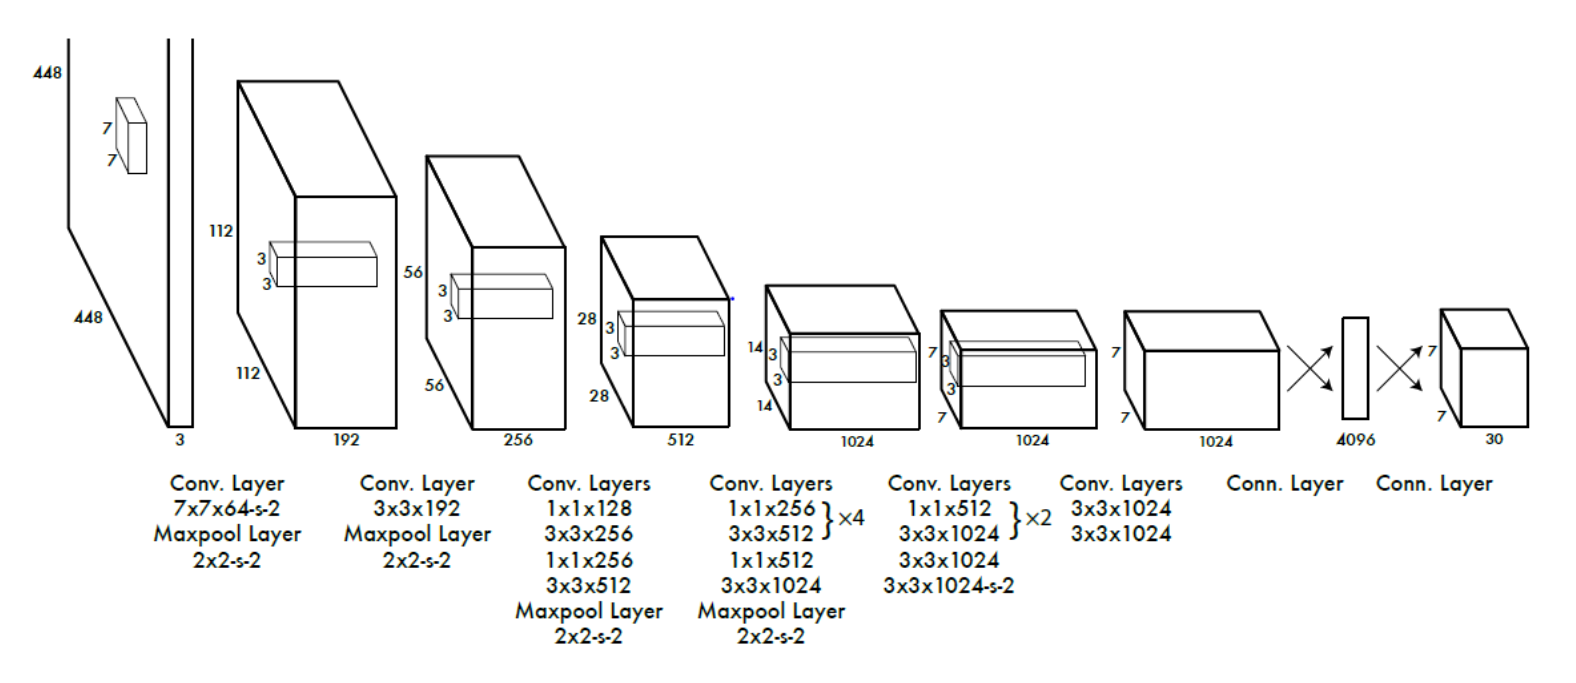

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    return x

In [35]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet")(img_inputs)
# x = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet')(img_inputs)
# x = layers.Dense(1024, kernel_initializer=tf.keras.initializers.TruncatedNormal())(x)

# x = conv_leaky_relu(img_inputs, 64, 7, 2)     # inputs, filter數量, filter size, stride
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 192, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 128, 1, 1)
# x = conv_leaky_relu(x, 256, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)


x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [36]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                              

#### Define loss

In [37]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


In [38]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

#### Start Training

In [40]:
dataset = DatasetGenerator().generate()

In [41]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [42]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/eric/YOLO-densenet121', max_to_keep=10, checkpoint_name='yolo')

In [43]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [44]:
from datetime import datetime

In [45]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path)) 

2023-11-22 18:32:29.119820, start training.


  0%|          | 0/4101 [00:00<?, ?it/s]2023-11-22 18:32:38.925530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-11-22 18:32:39.741500: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-22 18:32:39.817863: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-22 18:32:40.050364: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-22 18:32:40.050396: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this ma

InvalidArgumentError: Graph execution error:

Detected at node 'while/while/Pad_1' defined at (most recent call last):
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/s111062588/anaconda3/envs/DL-GPU-Eric/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2271029/4160458776.py", line 7, in <cell line: 2>
      train_step(image, labels, objects_num)
    File "/tmp/ipykernel_2271029/3342681033.py", line 12, in train_step
      loss = yolo_loss(predicts, labels, objects_num)
    File "/tmp/ipykernel_2271029/3972505928.py", line 14, in yolo_loss
      for i in tf.range(BATCH_SIZE):
    File "/tmp/ipykernel_2271029/3972505928.py", line 19, in yolo_loss
      for j in tf.range(object_num):
    File "/tmp/ipykernel_2271029/3972505928.py", line 20, in yolo_loss
      results = losses_calculation(predict, label[j:j+1, :])
    File "/tmp/ipykernel_2271029/4186528792.py", line 92, in losses_calculation
      response = tf.pad(response, objects_center_coord, "CONSTANT")
Node: 'while/while/Pad_1'
Paddings must be non-negative: 7 -1
	 [[{{node while/while/Pad_1}}]] [Op:__inference_train_step_227533]

#### Predict Test data

After training, we should run testing on the test data images. Since we should output a txt file in similar format as pascal_voc_training_data.txt, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].

##### Process YOLO's predictions

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [7, 7, 2, 20]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    threshold = P[max_conf_idx] * 0.5

    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num.append(idx[3])
            conf.append(P[idx])

            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin.append(xcenter - w / 2.0)
            ymin.append(ycenter - h / 2.0)

            xmax.append(xmin[-1] + w)
            ymax.append(ymin[-1] + h)

    return xmin, ymin, xmax, ymax, class_num, conf

In [ ]:
def process_outputs_ori(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

##### Build Test dataset Iterator

In [ ]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt_path = './ckpts/eric/YOLO-densenet121/yolo-'+str(EPOCHS)
print(ckpt_path)
ckpt.restore('./ckpts/eric/YOLO-densenet121/yolo-50')

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

#### Make Prediction and Output to txt file

To run the evaluation program we provide, you should output your prediction with this format(similar but different with pascal_voc_training_data.txt)

image_name   {xmin_i    ymin_i    xmax_i    ymax_i    class_i    confidence_score} (repeat number of objects times)

In [ ]:
output_file = open('./output/test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        for j in range(len(xmin)):
            xmin[j] = xmin[j] * (img_w[i] / IMAGE_SIZE)
            ymin[j] = ymin[j] * (img_h[i] / IMAGE_SIZE)
            xmax[j] = xmax[j] * (img_w[i] / IMAGE_SIZE)
            ymax[j] = ymax[j] * (img_h[i] / IMAGE_SIZE)
            output_file.write(img_name[i].numpy().decode('ascii')+" %d %d %d %d %d %f\n" % (xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        
        # #img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

#### Run Evaluation Metric

The evaluation program calculates mean Average Precision(mAP) of your output boxes. It will first sort your prediction by your confidence score, and get the Precision/Recall curve. Then the area under this curve is the mAP of this class.

We separated test data into 10 groups, and calculates the mAP of each class for each group. Your goal is to maximize the total mAP score.

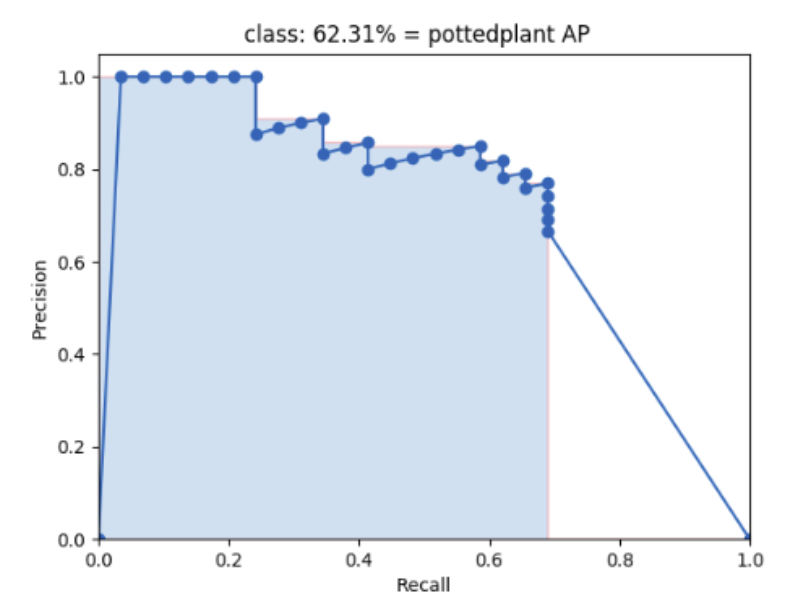

In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')

cap = pd.read_csv('./output/output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

#### Visualization

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [ ]:
import random

def random_file_from_directory(directory):
    if not os.path.isdir(directory):
        print(f"Error: '{directory}' is not a directory.")
        return None

    files = os.listdir(directory)
    if not files:
        print(f"No files found in '{directory}'.")
        return None

    random_file_list = []
    for _ in range(5):
        random_file = random.choice(files)
        random_file= os.path.join(directory, random_file)
        random_file_list.append(random_file)
    return random_file_list

folder_path = './dataset/VOCdevkit_test/VOC2007/JPEGImages'


In [ ]:
random_selected_file = random_file_from_directory(folder_path)
fig, axs = plt.subplots(1, len(random_selected_file), figsize=(15, 5))

for idx, file_path in enumerate(random_selected_file):
    np_img = cv2.imread(file_path)
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np_img / 255.0 * 2 - 1
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

    y_pred = YOLO(np_img, training=False)
    xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
    text = []
    for i in range(len(xmin)):
        class_name = classes_name[class_num[i]]
        cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
        cv2.putText(resized_img, class_name, (int(xmin[i]), int(ymin[i])), 2, 1.5, (0, 255, 255), 2)
        
        if xmin[i] < 0 or ymin[i] < 0 or xmax[i] < 0 or ymax[i] < 0:
            text_tmp = (class_name, conf[i], xmin[i], ymin[i], xmax[i], ymax[i], conf[i])
            text.append(text_tmp)
        else:
            text_tmp = (class_name, conf[i])
            text.append(text_tmp)
    print(f'pic{idx} = {text}')


    axs[idx].imshow(resized_img)
    axs[idx].set_title(f"Image {idx + 1}")  # Set title for each subplot
    axs[idx].axis('off')  # Hide axes
    
    # plt.imshow(resized_img)
plt.tight_layout()
plt.show()